<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Import-modules" data-toc-modified-id="Import-modules-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import modules</a></span></li><li><span><a href="#Load-the-datatest" data-toc-modified-id="Load-the-datatest-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load the datatest</a></span></li><li><span><a href="#Calculate-statistics:-the-out-of-memory-case" data-toc-modified-id="Calculate-statistics:-the-out-of-memory-case-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Calculate statistics: the out-of-memory case</a></span></li><li><span><a href="#References" data-toc-modified-id="References-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>References</a></span></li></ul></div>

# Introduction
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

**What?** How to compute out-of-memory statistics

</font>
</div>

# Import modules

In [31]:
import numpy as np
import os, csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 14, 5
rcParams['font.size'] = 20

# Load the datatest

<div class="alert alert-block alert-info">
<font color=black>

- The dataset comprises of two CSV files containing the hourly and daily count of bikes rented in the years between 2011 and 2012 within the Capital Bike-share system in Washington D.C., USA. 
- The data features the corresponding weather and seasonal information regarding the day of rental. 
- **pandas read_csv** allows you to stream into **chunks** of the desired size as DataFrame data structures so that you can access the features in a positional way or by recalling their label.
- Here, it is very important to notice that the iterator is instantiated by specifying a chunk size, that is, the number of rows the iterator has to return at every iteration. 
- The chunksize parameter can assume values from 1 to any value, though clearly the size of the mini-batch (the chunk retrieved) is strictly connected to your available memory to store and manipulate it in the following preprocessing phase.
- Bringing larger chunks into memory offers an advantage only in terms of disk access. 
- Smaller chunks require multiple access to the disk and, depending on the characteristics of your physical storage, a longer time to pass through the data. 
- Nevertheless, from a machine learning point of view, smaller or larger chunks make little difference for Scikit-learn out-of-core functions as they learn taking into account only one instance at a time, making them truly linear in computational cost.

</font>
</div>

In [22]:
source = '../DATASETS/LARGE_DATASETS/Bike-Sharing-Dataset/hour.csv'

CHUNK_SIZE = 1000
with open(source, 'rb') as R:
    iterator = pd.read_csv(R, chunksize=CHUNK_SIZE)
    for n, data_chunk in enumerate(iterator):
        print ('Size of uploaded chunk: %i instances, %i features' % (data_chunk.shape))
        # DATA PROCESSING placeholder
        # MACHINE LEARNING placeholder
        pass

Size of uploaded chunk: 1000 instances, 17 features
Size of uploaded chunk: 1000 instances, 17 features
Size of uploaded chunk: 1000 instances, 17 features
Size of uploaded chunk: 1000 instances, 17 features
Size of uploaded chunk: 1000 instances, 17 features
Size of uploaded chunk: 1000 instances, 17 features
Size of uploaded chunk: 1000 instances, 17 features
Size of uploaded chunk: 1000 instances, 17 features
Size of uploaded chunk: 1000 instances, 17 features
Size of uploaded chunk: 1000 instances, 17 features
Size of uploaded chunk: 1000 instances, 17 features
Size of uploaded chunk: 1000 instances, 17 features
Size of uploaded chunk: 1000 instances, 17 features
Size of uploaded chunk: 1000 instances, 17 features
Size of uploaded chunk: 1000 instances, 17 features
Size of uploaded chunk: 1000 instances, 17 features
Size of uploaded chunk: 1000 instances, 17 features
Size of uploaded chunk: 379 instances, 17 features


In [ ]:
# how to retrieve data
print ('Sample values: \n%s' % str(data_chunk.iloc[0]))

In [25]:
# An alternative is the following
SEP = ','
with open(source, 'rt') as R:
    iterator = csv.reader(R, delimiter=SEP)
    for n, row in enumerate(iterator):
        if n == 0:
            header = row
        else:
            # DATA PROCESSING placeholder
            # MACHINE LEARNING placeholder
            pass

    print('Total rows: %i' % (n+1))
    print('Header: %s' % ', '.join(header))
    print('Sample values: %s' % ', '.join(row))

Total rows: 17380
Header: instant, dteday, season, yr, mnth, hr, holiday, weekday, workingday, weathersit, temp, atemp, hum, windspeed, casual, registered, cnt
Sample values: 17379, 2012-12-31, 1, 1, 12, 23, 0, 1, 1, 1, 0.26, 0.2727, 0.65, 0.1343, 12, 37, 49


# Calculate statistics: the out-of-memory case

<div class="alert alert-block alert-info">
<font color=black>

- Given the fact that you are streaming data and it isn't possible to upload all the data in-memory, you have to calculate them by passing through all the data or at least
a part of it (sampling is always a viable solution).
- The average doesn't pose any particular problems because you just need to keep a sum of the values seen and a count of the instances. 
- For the variance you need to know the mean μ, which you are also just learning incrementally from the stream. 
- However, the formulation can be explicated as follows:
 
</font>
</div>

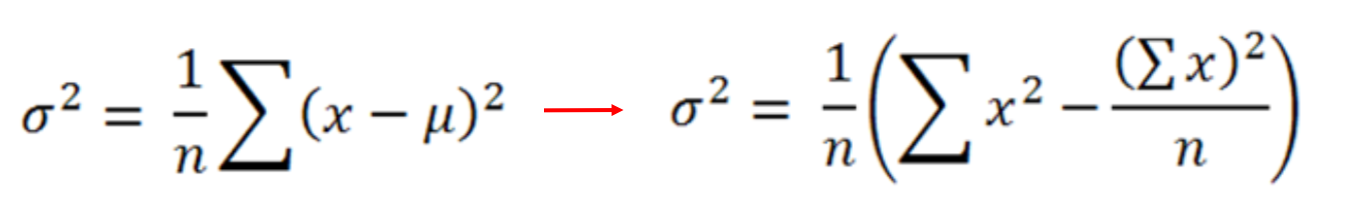

<div class="alert alert-block alert-info">
<font color=black>

- We can calculate the running mean, standard deviation, and range reporting the final result and plot how such stats changed as data was streamed from disk
- By plotting the values present in the lists, we can examine how much the estimates fluctuated with respect to the final figures and get an idea about how many instances are required before getting a stable mean and standard deviation estimate
- On the contrary, if we had used the **shuffled** the dataset, we could have obtained a couple of much more stable and quickly converging estimates. Consequently, we would have learned an approximate but more reliable estimate of the mean and standard deviation observing fewer instances from the stream

</font>
</div>

In [28]:
SEP = ','
running_mean = list()
running_std = list()
with open(source, 'r') as R:
    iterator = csv.DictReader(R, delimiter=SEP)
    x = 0.0
    x_squared = 0.0
    for n, row in enumerate(iterator):
        temp = float(row['temp'])
        if n == 0:
            max_x, min_x = temp, temp
        else:
            max_x, min_x = max(temp, max_x), min(temp, min_x)
            x += temp
        x_squared += temp**2
        running_mean.append(x / (n+1))
        running_std.append(((x_squared - (x**2)/(n+1))/(n+1))**0.5)
        # DATA PROCESSING placeholder
        # MACHINE LEARNING placeholder
        pass
    print('Total rows: %i' % (n+1))
    print('Feature \'temp\': mean=%0.3f, max=%0.3f, min=%0.3f,\
    sd=%0.3f' % (running_mean[-1], max_x, min_x, running_std[-1]))

Total rows: 17379
Feature 'temp': mean=0.497, max=1.000, min=0.020,    sd=0.193


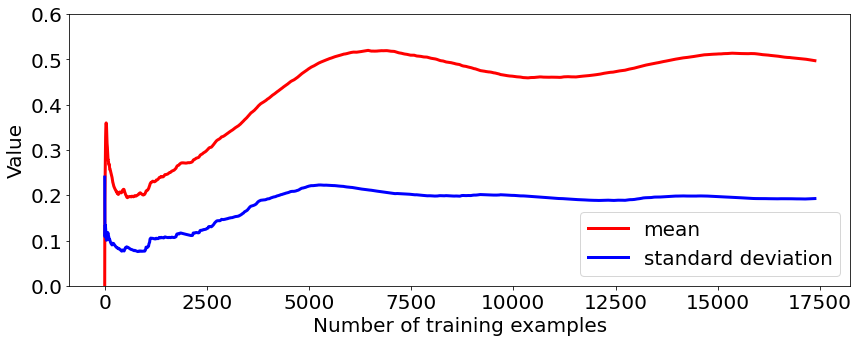

In [33]:
plt.plot(running_mean, 'r-', lw=3, label='mean')
plt.plot(running_std, 'b-', lw=3, label='standard deviation')
plt.ylim(0.0, 0.6)
plt.xlabel('Number of training examples')
plt.ylabel('Value')
plt.legend(loc='lower right', numpoints=1)
plt.show()

# References
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

- Sjardin, Bastiaan, Luca Massaron, and Alberto Boschetti. Large Scale Machine Learning with Python. Packt Publishing Ltd, 2016.<br>
-https://github.com/packtpublishing/large-scale-machine-learning-with-python 
    
</font>
</div>